# DOGGY DELIGHTS

Welcome to the Doggy Delights Project!

Doggy Delights is a large online store which sells products for dogs.

As an analyst, I am working with the marketing department to identify ways to increase their revenue. We've gathered a list of hypotheses that might help us achieve this goal, and my task is to prioritize these hypotheses, analyze A/B tests, and analyze the results.

In the first part of this project, I will focus on prioritizing the hypotheses. The dataset for this section contains nine hypotheses, each with assigned values for reach, impact, confidence, and effort. I will use the ICE and RICE frameworks to rank these hypotheses and determine which ones to test first. This involves calculating and comparing their scores and explaining any changes in prioritization when switching from ICE to RICE.

The second part of the project involves analyzing the results of an A/B test. The data includes details on orders and visits, such as transaction IDs, user IDs, dates, revenue, and the group to which each user was assigned. I will preprocess this data to ensure accuracy, removing any errors such as users appearing in both test groups.

My analysis will cover various aspects of the test results. I will graph the cumulative revenue and average order size for each group, compare conversion rates, and identify anomalies in order prices and user behavior. This includes calculating the 95th and 99th percentiles for both the number of orders per user and order prices. Additionally, I will perform statistical tests to determine the significance of any differences in conversion rates and average order sizes between the groups.

Finally, based on the results, I will make informed decisions about the test. This could involve identifying a leading group, concluding that there is no significant difference between the groups, or deciding to continue the test for further analysis.

Throughout this project, my goal is to provide clear, data-driven insights that will help inform strategic decisions aimed at boosting our online store's revenue.

Let's start with the basic; importing libraries and datasets:

In [1]:
# Python Standard Libraries
import datetime
import json
import os

# Third Party Libraries
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

## Dataframes Upload

Here we'll upload the dataframes needed for this project and we perform some transformations

In [2]:
# Bring the Data
hpdf = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/hypotheses_us.csv', delimiter=';', skipinitialspace=True)
ordersdf = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/orders_us.csv')
visitsdf = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/visits_us.csv')

## Hypothesis DataFrame = hdpf

First, we start by performing some transformations

In [3]:
hpdf.columns = hpdf.columns.str.strip()
hpdf.columns = hpdf.columns.str.lower()

Now let's see what we've got here:

In [4]:
# Let's show'em
print(hpdf.info())
print('_'*50)
print(hpdf.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None
__________________________________________________
                                          hypothesis  reach  impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   confidence  effort  
0           8       6  
1           4      10  
2         

Let's use a function for better readability of the hypotheses:

In [5]:
print('Hypotheses by Index')
print('')
for index, hypothesis in enumerate(hpdf['hypothesis'], start=1):
    print(f"{index}. {hypothesis}")

Hypotheses by Index

1. Add two new channels for attracting traffic. This will bring 30% more users
2. Launch your own delivery service. This will shorten delivery time
3. Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
4. Change the category structure. This will increase conversion since users will find the products they want more quickly
5. Change the background color on the main page. This will increase user engagement
6. Add a customer review page. This will increase the number of orders
7. Show banners with current offers and sales on the main page. This will boost conversion
8. Add a subscription form to all the main pages. This will help you compile a mailing list
9. Launch a promotion that gives users discounts on their birthdays


Alright, we are going to create short aliases for these hypothesis. We'll need them further:

In [6]:
# Let's assign aliases to these hypothesis:
aliases = [
    "Two New Channels",
    "Delivery Service",
    "Product Recommendation Block",
    "Category Structure Change",
    "Background Color Main Page",
    "Customer Reviews",
    "Banners",
    "Subscription Form",
    "Birthday Promotions"
]

# Let's create the column
hpdf['hypothesis_alias'] = aliases

# Let's verify
print(hpdf[['hypothesis', 'hypothesis_alias']])

                                          hypothesis  \
0  Add two new channels for attracting traffic. T...   
1  Launch your own delivery service. This will sh...   
2  Add product recommendation blocks to the store...   
3  Change the category structure. This will incre...   
4  Change the background color on the main page. ...   
5  Add a customer review page. This will increase...   
6  Show banners with current offers and sales on ...   
7  Add a subscription form to all the main pages....   
8  Launch a promotion that gives users discounts ...   

               hypothesis_alias  
0              Two New Channels  
1              Delivery Service  
2  Product Recommendation Block  
3     Category Structure Change  
4    Background Color Main Page  
5              Customer Reviews  
6                       Banners  
7             Subscription Form  
8           Birthday Promotions  


## Orders DataFrame = ordersdf

First, we start by performing some transformations

In [7]:
ordersdf.columns = ordersdf.columns.str.strip()
ordersdf.columns = ordersdf.columns.str.lower()
ordersdf['date'] = pd.to_datetime(ordersdf['date'])
ordersdf.rename(columns={"transactionid": "transaction_id", "visitorid": "visitor_id"}, inplace=True)

Let's see what we've got here:

In [8]:
print(ordersdf.info())
print('_'*50)
print(ordersdf.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB
None
__________________________________________________
   transaction_id  visitor_id       date  revenue group
0      3667963787  3312258926 2019-08-15     30.4     B
1      2804400009  3642806036 2019-08-15     15.2     B
2      2961555356  4069496402 2019-08-15     10.2     A
3      3797467345  1196621759 2019-08-15    155.1     B
4      2282983706  2322279887 2019-08-15     40.5     B


In a previous iteration of this project, there was a suspicion of some outliers lurking in the revenue values. Let's see if we can find them:

In [9]:
ordersdf['revenue'].describe()

count     1197.000000
mean       131.491646
std        603.004729
min          5.000000
25%         20.800000
50%         50.200000
75%        130.400000
max      19920.400000
Name: revenue, dtype: float64

And here it is; there's a max value of 19,920, which indicates one of two possibilities; Either:
* This is an error.
* Someone loves dogs too much in order to buy almost 20 grand in supplies.

This outlier (and others) could introduce bias to our analysis, so we need to get rid of them.

By applying the z-score statistical method, we can identify outliers that lie beyond 3 standard deviations. If they do not represent a significant quantity from the total of regiestries, we can remove them in order to make a better analysis.

Let's find those outliers by calculating the Z-Score:

In [10]:
z_scores_revenue = stats.zscore(ordersdf['revenue'])
threshold = 3

outliers_z_score = ordersdf[(z_scores_revenue > threshold) | (z_scores_revenue < -threshold)]

print("Outliers using Z-Score:")
print(outliers_z_score['revenue'].sort_values(ascending=False))

Outliers using Z-Score:
425     19920.4
1196     3120.1
Name: revenue, dtype: float64


The calculation reveals there are 2 possible outliers in the dataframe, representing roughly 0.16% of the total records. If we eliminate them, they will not significantly impact further analysis.

In [11]:
ordersdf = ordersdf[~ordersdf.index.isin(outliers_z_score.index)]

# Let's verify how our dataframe looks in the end:
print("New Dataframe (No Outliers):")
print(ordersdf['revenue'].describe())

New Dataframe (No Outliers):
count    1195.000000
mean      112.430962
std       168.539785
min         5.000000
25%        20.800000
50%        50.200000
75%       130.250000
max      1450.200000
Name: revenue, dtype: float64


Alright, this seems more decent. Let's continue.

## Visits DataFrame = visitsdf

Alright, let's perform some transformations to our last dataframe

In [12]:
visitsdf.columns = visitsdf.columns.str.strip()
visitsdf.columns = visitsdf.columns.str.lower()
visitsdf['date'] = pd.to_datetime(visitsdf['date'])

Now let's see what we've got

In [13]:
print(visitsdf.info())
print('_'*50)
print(visitsdf.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
__________________________________________________
        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756


## Part 1.- ICE AND RICE SCORE

In this first part of this project, I will focus on prioritizing a set of hypotheses aimed at increasing revenue for "Doggy Delights." I have collected nine hypotheses, each evaluated based on Reach, Impact, Confidence, and Effort. 

Using the `ICE` framework (Impact, Confidence, Effort), I will rank these hypotheses to determine which ones hold the most potential for improving revenue. 

Additionally, I will apply the `RICE`framework (Reach, Impact, Confidence, Effort) to see how the prioritization might change when considering the reach of each hypothesis. This will help in identifying the most promising strategies to test and implement.

The prioritization of hypotheses using the ICE and RICE frameworks results in different rankings due to the additional factor included in the RICE score—reach. Here's how the prioritization changes and the explanation behind it:

In [14]:
# ICE Score
hpdf['ICE'] = hpdf['impact'] * hpdf['confidence'] / hpdf['effort']
print('ICE Score')
print(hpdf[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

print('')
print('_'*80)
print('')

# RICE Score
hpdf['RICE'] = hpdf['reach'] * hpdf['impact'] * hpdf['confidence'] / hpdf['effort']
print('RICE Score')
print(hpdf[['hypothesis','RICE']].sort_values(by='RICE', ascending=False))

ICE Score
                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000

________________________________________________________________________________

RICE Score
                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners 

In <b>ICE</b>, the ranking is based on impact, confidence, and effort alone. Hypotheses with high impact and confidence but relatively low effort rank higher. This ranking can favor hypotheses that may not have broad reach but are expected to have a high impact on those they do affect.

<b>RICE</b> incorporates the reach factor, which estimates the number of users or the extent of impact a hypothesis can have. This factor amplifies the scores for hypotheses that can affect a larger portion of the user base. In other words, the reach factor can significantly shift the ranking.

For example, "Add a subscription form to all the main pages" ranks much higher in RICE due to its potential to reach a broad audience, despite having a lower ICE score. The impact of reaching more users outweighs the effort required in this framework. Same case with the hypotheses "Add product recommendation blocks" and "Show banners with current offers"; both have higher reach, which boosts their RICE scores. This reflects a strategy that prioritizes changes affecting more users.

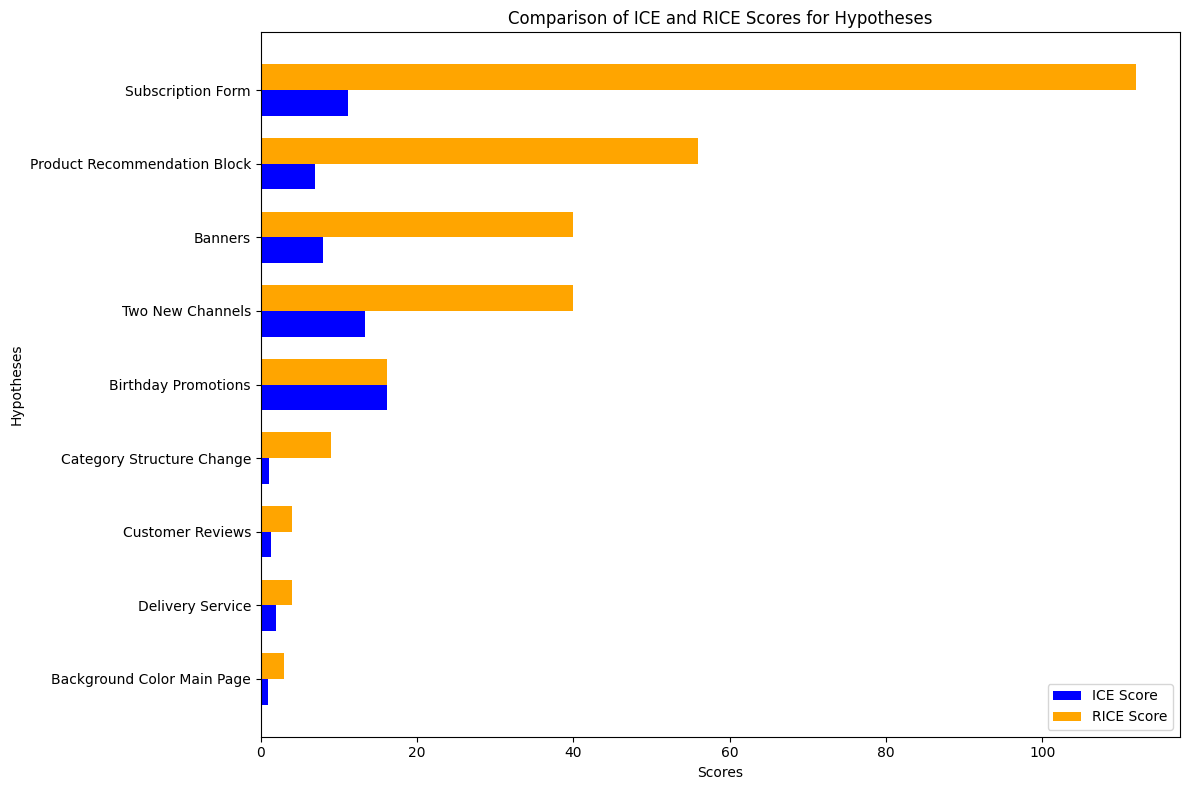

In [15]:
# First, we sort hypotheses by RICE score for better visualization
hpdf_sorted = hpdf.sort_values(by='RICE', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(hpdf_sorted))

# Bars for ICE and RICE
bars1 = ax.barh(index, hpdf_sorted['ICE'], bar_width, label='ICE Score', color='blue')
bars2 = ax.barh(index + bar_width, hpdf_sorted['RICE'], bar_width, label='RICE Score', color='orange')

# Label and title configuration
ax.set_ylabel('Hypotheses')
ax.set_xlabel('Scores')
ax.set_title('Comparison of ICE and RICE Scores for Hypotheses')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(hpdf_sorted['hypothesis_alias']) # <=== AND HERE'S THE REASON WHY WE CREATED HYPOTHESIS ALIASES
ax.legend()

# Display this fricking thing
plt.tight_layout()
plt.show()

In Summary:

* ICE is useful for focusing on the effectiveness of changes based on a smaller, more targeted user base, emphasizing quick wins with high confidence.

* RICE provides a broader perspective by including reach, making it valuable for understanding which changes can potentially impact a larger segment of users, thus influencing overall growth and user engagement.

By considering both frameworks, we can achieve a balanced approach to prioritize hypotheses that not only have high impact but also can reach a significant portion of the store's user base.

## Part 2.- A/B Test Analysis

In the second part of this project, I will analyze the results of an A/B test conducted for "Doggy Delights." The objective is to evaluate how different strategies impact the store's performance by examining data from two groups involved in the test. 

Let's start by calculating the total number of visitors and orders for each experimental group. Since we don't need the date column, we'll remove it using the drop() method with the axis=1 parameter. Then, we'll group the data by the A/B test groups column using the groupby() method with the as_index=False parameter. To find the total number of visitors and orders in each group, we’ll use aggregation functions:

In [16]:
orders_group_analysis = (
    ordersdf.drop(['date'], axis=1)
    .groupby('group', as_index=False)
    .agg({'revenue': 'sum'})
)

print('Orders A/B Testing Analysis')
print(orders_group_analysis)

print('_'*50)

visitsdf_group_analysis = (
    visitsdf.drop(['date'], axis=1)
    .groupby('group', as_index=False)
    .agg({'visits': 'sum'})
)

print('Visits A/B Testing Analysis')
print(visitsdf_group_analysis)

Orders A/B Testing Analysis
  group  revenue
0     A  64554.9
1     B  69800.1
__________________________________________________
Visits A/B Testing Analysis
  group  visits
0     A   18736
1     B   18916


In [17]:
visits_orders_merged= pd.merge(ordersdf, visitsdf, on=['date', 'group'], how='left')
print(visits_orders_merged.head(10))

   transaction_id  visitor_id       date  revenue group  visits
0      3667963787  3312258926 2019-08-15     30.4     B     544
1      2804400009  3642806036 2019-08-15     15.2     B     544
2      2961555356  4069496402 2019-08-15     10.2     A     628
3      3797467345  1196621759 2019-08-15    155.1     B     544
4      2282983706  2322279887 2019-08-15     40.5     B     544
5       182168103   935554773 2019-08-15     35.0     B     544
6       398296753  2900797465 2019-08-15     30.6     B     544
7      2626614568    78758296 2019-08-15     20.1     A     628
8      1576988021   295230930 2019-08-15    215.9     A     628
9      1506739906  1882260405 2019-08-15     30.5     B     544


In [18]:
visits_orders_merged_analysis = (
    visits_orders_merged.drop(['date', 'transaction_id', 'visitor_id'], axis=1)
    .groupby('group', as_index=False)
    .agg({'visits': 'sum', 'revenue': 'sum'})
)

visits_orders_merged_analysis['revenue_to_visit_ratio'] = (visits_orders_merged_analysis['revenue']/visits_orders_merged_analysis['visits']).map(lambda x: "{0:.4f}".format(x))

print(visits_orders_merged_analysis)

  group  visits  revenue revenue_to_visit_ratio
0     A  339433  64554.9                 0.1902
1     B  389029  69800.1                 0.1794


The ratio of orders to visitors is higher in group A than in group B.

Additionally, I will perform several analysis and calculations, such as visualizing the cumulative revenue and average order size for each group to identify trends and differences, and comparing the relative difference in average order size between the groups. Conversion rates will be calculated and plotted to assess each group's effectiveness. 

Further, I will explore scatter plots to detect anomalies in the number of orders and order prices. Statistical significance tests will be performed to determine if observed differences in conversion rates and average order sizes are meaningful. 

Based on these analyses, I will draw conclusions and make recommendations on whether to consider one group as superior, conclude that there is no significant difference, or continue the test.

### 1. Cumulative Revenue by Group

Let's start by plotting the cumulative revenue for Group A and Group B throughout the month the test lasted:

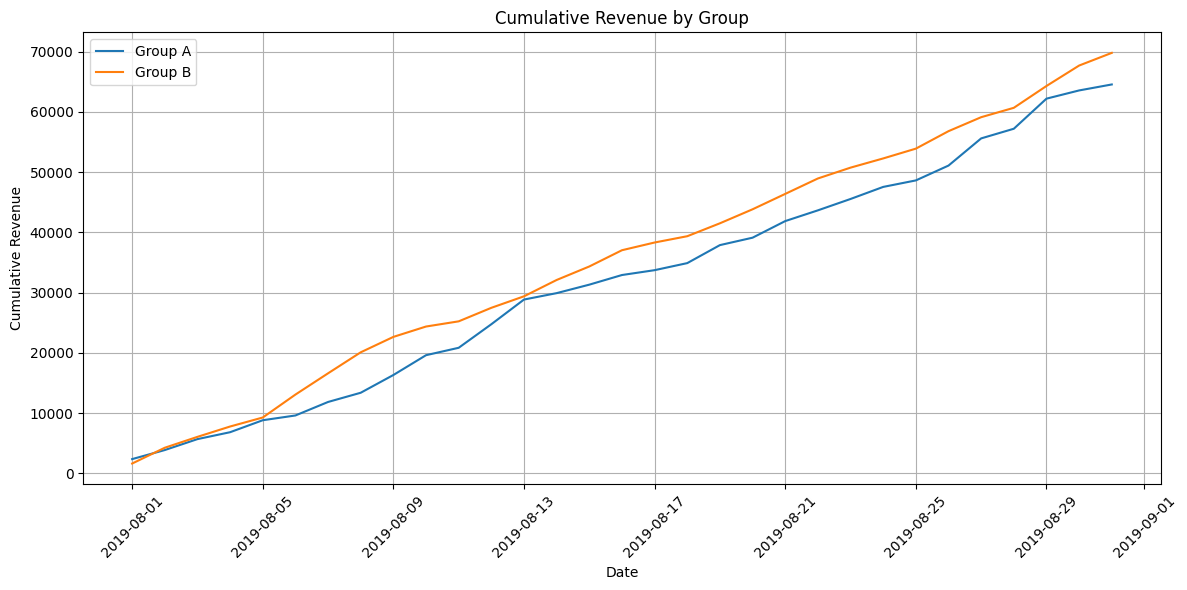

In [19]:
# First, we group by date and test group, using the merge of visitsdf and ordersdf, then sum the revenue
daily_revenue = visits_orders_merged.groupby(['date', 'group'])['revenue'].sum().reset_index()

# Then, we calculate cumulative revenue
daily_revenue['cumulative_revenue'] = daily_revenue.groupby('group')['revenue'].cumsum()

# Let's Plot this thing
plt.figure(figsize=(12, 6))
for group in daily_revenue['group'].unique():
    group_data = daily_revenue[daily_revenue['group'] == group]
    plt.plot(group_data['date'], group_data['cumulative_revenue'], label=f'Group {group}')

plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.title('Cumulative Revenue by Group')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


The graph illustrates the cumulative revenue generated by two test groups, A and B, over a period of one month. At the beginning of the month, both groups start with similar revenue figures, but as time progresses, Group B consistently outperforms Group A. Around mid-month, Group B's revenue starts to diverge more significantly, maintaining a higher cumulative revenue compared to Group A for the remainder of the period.

This indicates that the interventions or changes tested in Group B were more effective in driving sales than those in Group A. By the end of the month, the gap between the two groups is quite noticeable, suggesting that the strategies implemented for Group B could potentially be adopted more broadly to enhance overall revenue. The results from this test support the notion that Group B's approach has a substantial positive impact on revenue generation.

Let's visualize now by order size:

### 2. Cumulative Average Order Size by Group

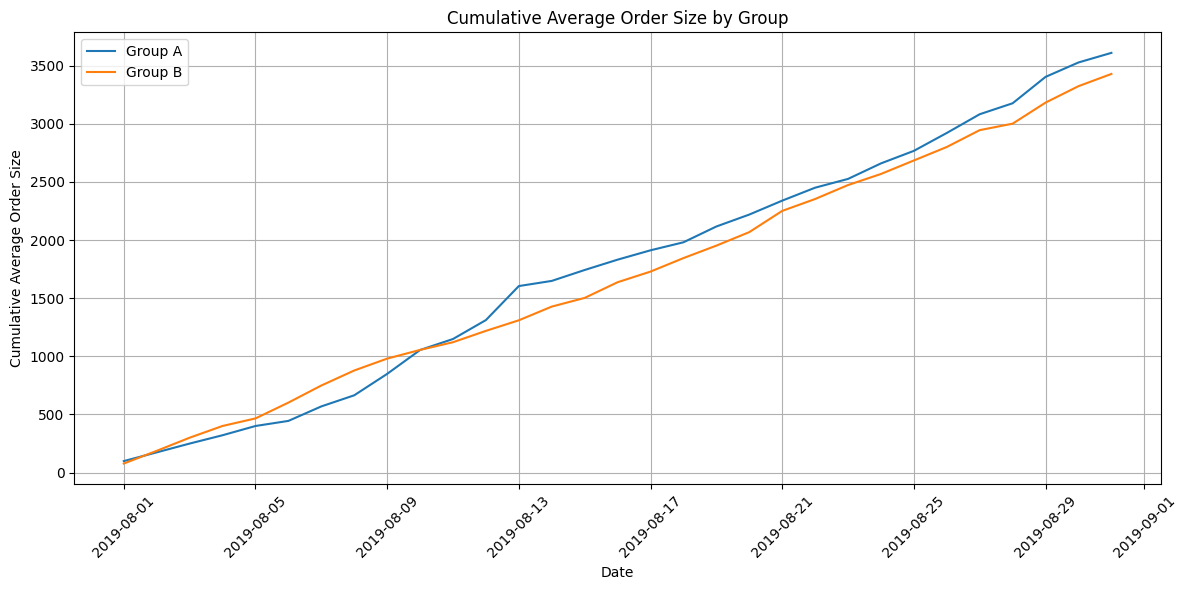

In [20]:
# We start by calculating average order size
visits_orders_merged['order_size'] = visits_orders_merged['revenue']

# Then, we group by date and group test, then we calculate the average order size
daily_order_size = visits_orders_merged.groupby(['date', 'group']).agg(
    total_revenue=('revenue', 'sum'),
    total_orders=('transaction_id', 'count')
).reset_index()

# Let's calculate average order size
daily_order_size['average_order_size'] = daily_order_size['total_revenue'] / daily_order_size['total_orders']

# Let's calculate cumulative average order size
daily_order_size['cumulative_average_order_size'] = daily_order_size.groupby('group')['average_order_size'].cumsum()

# Let's show this thing
plt.figure(figsize=(12, 6))
for group in daily_order_size['group'].unique():
    group_data = daily_order_size[daily_order_size['group'] == group]
    plt.plot(group_data['date'], group_data['cumulative_average_order_size'], label=f'Group {group}')

plt.xlabel('Date')
plt.ylabel('Cumulative Average Order Size')
plt.title('Cumulative Average Order Size by Group')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


Looking by this perspective, both groups display similar trends initially, but Group A starts to pull ahead around mid-August. By the end of the month, Group A consistently maintains a higher cumulative average order size compared to Group B.

When we compare this with the cumulative revenue graph, it's clear that although Group B generated higher overall revenue, Group A achieved this with larger average order sizes. This suggests that while Group B had more frequent or numerous orders, the individual order values in Group A were generally higher. This indicates that the marketing strategies or changes tested in Group B were effective in increasing the number of transactions, but Group A's approach led to larger individual purchases.

This insight can help tailor future strategies to balance both order frequency and order size for optimal revenue growth.

### 3. Relative Difference in Cumulative Average Order Size for Group B Compared to Group A

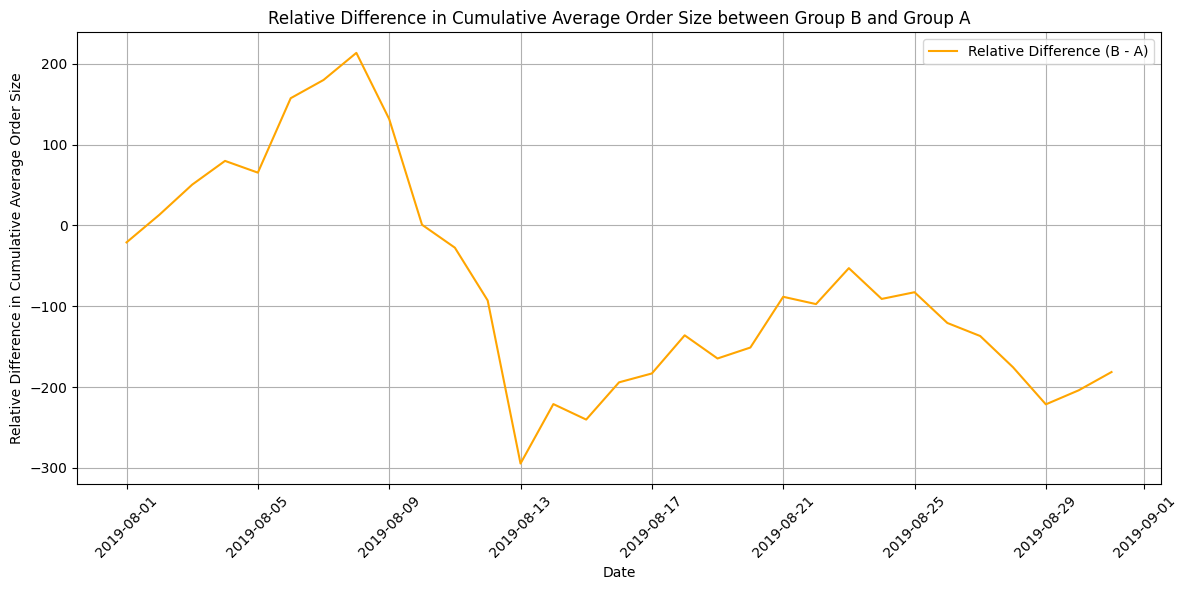

In [21]:
# Let's start by making a Pivot from the DataFrame we've previously used to get separate columns for each group
pivot_df = daily_order_size.pivot(index='date', columns='group', values='cumulative_average_order_size').reset_index()

# Let's ensure both groups are present
if 'A' in pivot_df.columns and 'B' in pivot_df.columns:
    # Calculation of the relative difference (Group B compared to Group A)
    pivot_df['relative_difference'] = pivot_df['B'] - pivot_df['A']

    # Let's show this thing
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df['date'], pivot_df['relative_difference'], label='Relative Difference (B - A)', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Relative Difference in Cumulative Average Order Size')
    plt.title('Relative Difference in Cumulative Average Order Size between Group B and Group A')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Both groups A and B must be present in the data.")


This graph displaying the relative difference in cumulative average order size between Groups B and A illustrates how the average order sizes of the two groups compare over time. 

Initially, Group B's average order size is higher, peaking around August 9. However, there is a significant shift after this date, with Group A's average order size surpassing that of Group B, creating a noticeable downward trend in the difference. By the end of the period, Group A consistently maintains a higher average order size.

In relation to the previous graphs, this trend supports the inference that while Group B initially saw higher average order sizes, the strategies employed by Group A ultimately led to more substantial individual purchases over time. This suggests that the interventions or marketing strategies in Group A were more effective in increasing the value of each order. Therefore, future efforts should focus on analyzing what specific actions in Group A contributed to this shift and how they can be replicated or enhanced to maximize revenue by balancing the frequency of orders with their value.

### 4.- Conversion Rate for Each Group as the Ratio of Orders to the Number of Visits (for each day).

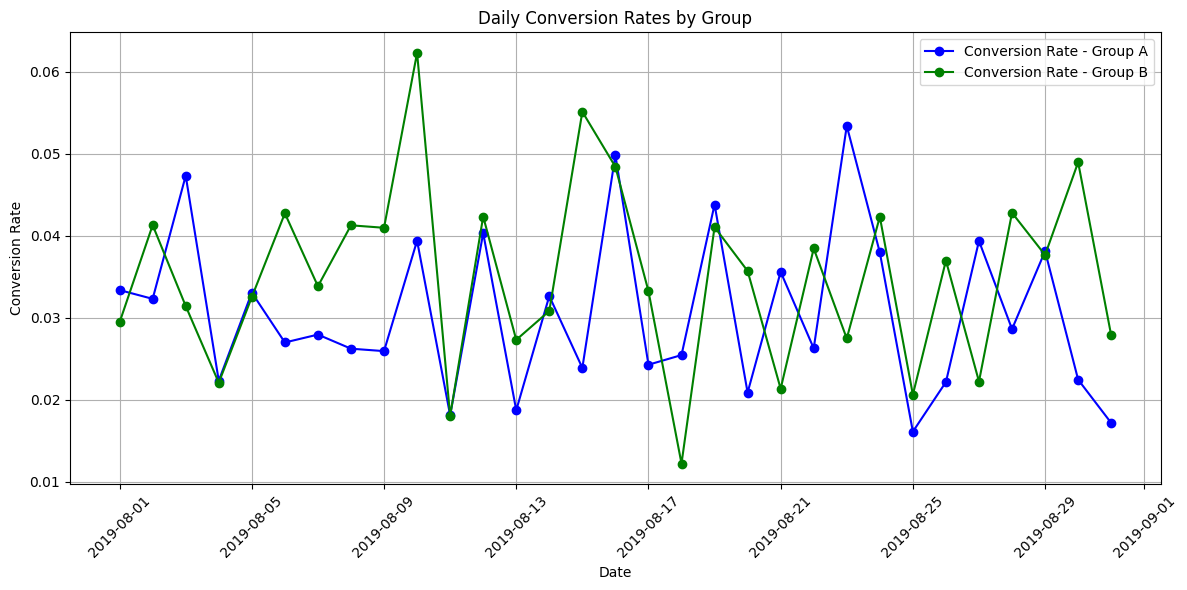

In [22]:
# Let´s start by grouping by date and test group, then calculate total orders and total visits
daily_data = visits_orders_merged.groupby(['date', 'group']).agg(
    total_orders=('transaction_id', 'count'),
    total_visits=('visits', 'mean')  # This is mean visits per day; assuming each row represents one order
).reset_index()

# Now let's calculate conversion rate as orders/visits
daily_data['conversion_rate'] = daily_data['total_orders'] / daily_data['total_visits']

# Let's create a Pivot to get separate columns for each group
pivot_df = daily_data.pivot(index='date', columns='group', values='conversion_rate').reset_index()

# Ensure both groups are present
if 'A' in pivot_df.columns and 'B' in pivot_df.columns:
    # Step 4: Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(pivot_df['date'], pivot_df['A'], label='Conversion Rate - Group A', color='blue', marker='o')
    plt.plot(pivot_df['date'], pivot_df['B'], label='Conversion Rate - Group B', color='green', marker='o')

    plt.xlabel('Date')
    plt.ylabel('Conversion Rate')
    plt.title('Daily Conversion Rates by Group')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Both groups A and B must be present in the data.")


The graph depicting the relative difference in cumulative average order size between Group B and Group A shows significant fluctuations over the month. 

Initially, Group B had a higher average order size, peaking around August 9. However, after this date, Group A's average order size surpassed Group B's, resulting in a negative relative difference. This trend persisted for the remainder of the month, indicating that Group A consistently achieved higher average order sizes compared to Group B.

The daily conversion rates graph further supports these observations. Although Group B often exhibited higher conversion rates, the increased frequency of orders did not translate into larger average order sizes. This suggests that while Group B was more effective at converting visits to orders, Group A's fewer conversions resulted in larger, more valuable transactions. Consequently, Group B's strategy seems to be better at driving overall revenue through volume, whereas Group A excels in maximizing the value of individual transactions. These insights highlight the need for a balanced approach that leverages the strengths of both strategies to optimize both conversion rates and order values.

### 5. Scatter Plot of the Number of Orders Per User

Now we're going to illustrate a distribution with the number of orders placed by each user:

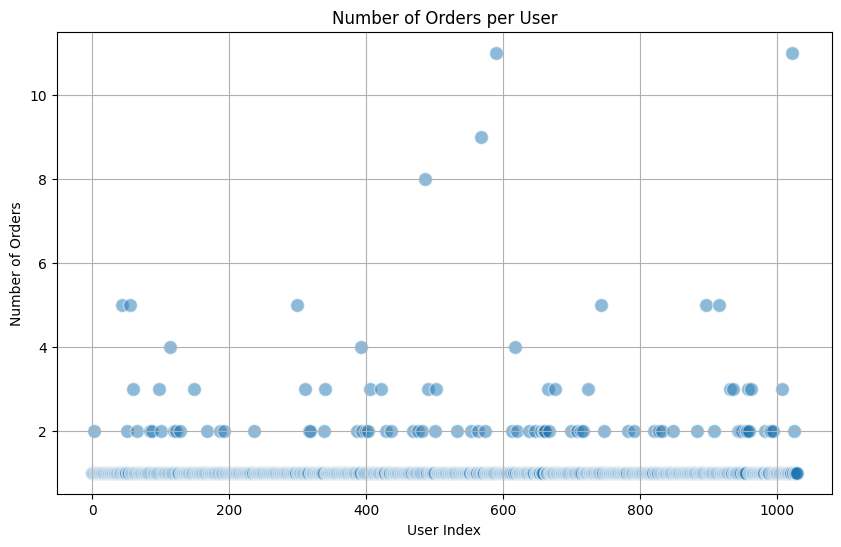

In [23]:
# Let's calculate the number of orders per user
orders_per_user = visits_orders_merged.groupby('visitor_id').size().reset_index(name='num_orders')

# Let's plot this thing
plt.figure(figsize=(10, 6))
plt.scatter(orders_per_user.index, orders_per_user['num_orders'], alpha=0.5, edgecolors='w', s=100)
plt.xlabel('User Index')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per User')
plt.grid(True)
plt.show()

Let's bear in mind each point representing a user and their corresponding order count.

The scatter plot reveals that the majority of users placed between one and two orders, indicating a common purchasing behavior pattern among the customer base. There are a few users who placed significantly more orders, with some reaching as high as 10 orders, but these cases are outliers (apart from the ones we deleted at the very beginning of this project). This suggests that while most users engage in minimal purchasing activity, a small segment of highly engaged users contributes disproportionately to the total number of orders.

The presence of these outliers highlights opportunities for targeted marketing and customer retention strategies. By identifying and understanding the characteristics of these high-frequency purchasers, the store can develop personalized incentives to encourage continued engagement and increase the lifetime value of these customers. Additionally, exploring why the majority of users are making only one or two purchases can help in designing strategies to boost order frequency among the broader customer base. 

Overall, this analysis underscores the importance of balancing efforts between retaining high-value customers and encouraging more frequent purchases from the general user population.

Now, it's time to perform some statistic analyses.

### 6.- Calculation of the 95th and 99th Percentiles for the Number of Orders Per User. 

Here, we'll define the point at which a data point becomes an <b>anomaly</b>.

In [24]:
# Percentile Calculation
percentile_95_opu = np.percentile(orders_per_user['num_orders'], 95)
percentile_99_opu = np.percentile(orders_per_user['num_orders'], 99)

print(f"95th percentile for number of orders per user: {percentile_95_opu}")
print(f"99th percentile for number of orders per user: {percentile_99_opu}")

# Defining anomaly thresholds
anomaly_threshold_95_opu = percentile_95_opu
anomaly_threshold_99_opu = percentile_99_opu

print(f"Anomaly threshold (95th percentile): {anomaly_threshold_95_opu}")
print(f"Anomaly threshold (99th percentile): {anomaly_threshold_99_opu}")


95th percentile for number of orders per user: 2.0
99th percentile for number of orders per user: 4.0
Anomaly threshold (95th percentile): 2.0
Anomaly threshold (99th percentile): 4.0


These calculations tell us the next:

* 95th Percentile: Users who place more than 2 orders are in the top 5% of order activity. These users can be targeted for special loyalty programs or promotions due to their high engagement.

* 99th Percentile: Users placing more than 4 orders are extremely engaged and represent the top 1% of order activity. These users are critical to business success and warrant special attention, such as personalized offers or exclusive deals.

### 7.- Scatter Plot of Order Prices

Let's see what happes if we illustrate the distribution of revenue generated per order across all transactions.

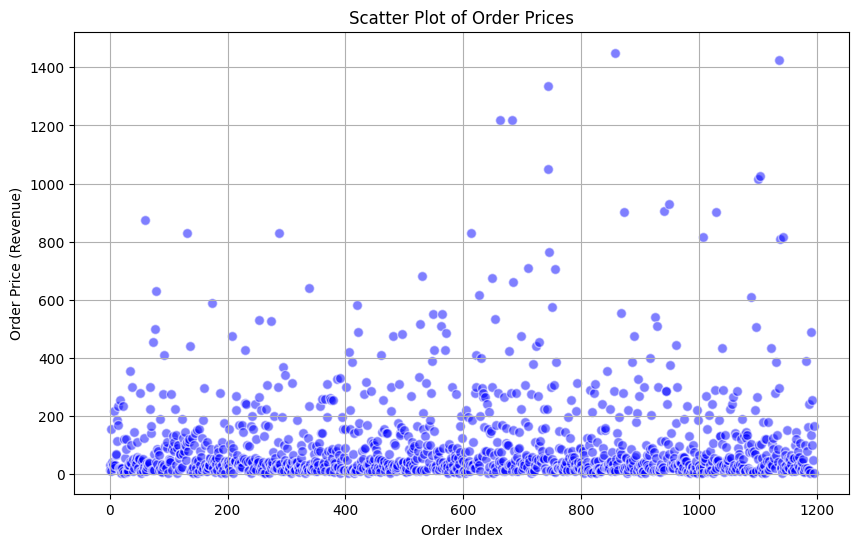

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(ordersdf.index, ordersdf['revenue'], alpha=0.5, c='blue', edgecolors='w', s=50)
plt.title('Scatter Plot of Order Prices')
plt.xlabel('Order Index')
plt.ylabel('Order Price (Revenue)')
plt.grid(True)
plt.show()


Most orders fall within the lower price range, clustering below $200, indicating that a majority of customers make smaller purchases. This dense cluster suggests that the store’s typical transaction is relatively low in value, likely reflecting frequent, everyday purchases or lower-cost items.

However, there are notable outliers with significantly higher order prices, reaching up to $1400. These outliers, although fewer in number, represent high-value transactions that can substantially impact overall revenue. The presence of these high-value orders indicates that while most customers make smaller purchases, there is a segment of the customer base that contributes disproportionately through large transactions. 

Identifying and understanding the characteristics of these high-value customers could provide opportunities for targeted marketing strategies, aiming to enhance customer loyalty and increase the frequency of such lucrative transactions. 

Balancing efforts to boost the number of smaller purchases with strategies to attract and retain high-value customers could optimize the store’s revenue growth.

### 8.- Calculation of the 95th and 99th Percentiles of Order Prices

Similar to the calculation of percentiles from orders per user, here we'll define the point at which a data point becomes an <b>anomaly</b>.

In [26]:
percentile_95_oprices = ordersdf['revenue'].quantile(0.95)
percentile_99_oprices = ordersdf['revenue'].quantile(0.99)

# Define the anomaly threshold (usually the 99th percentile)
anomaly_threshold_oprices = percentile_99_oprices

print(f"95th Percentile: {percentile_95_oprices}")
print(f"99th Percentile: {percentile_99_oprices}")
print(f"Anomaly Threshold (99th Percentile): {anomaly_threshold_oprices}")

95th Percentile: 425.83
99th Percentile: 877.0119999999986
Anomaly Threshold (99th Percentile): 877.0119999999986


In analyzing order prices, <b>any order price above 877 is considered an anomaly, as it falls beyond the 99th percentile</b>. This means that 1% of the order prices are higher than this threshold.

The calculations for the 95th and 99th percentiles of order prices reveal important insights into the purchasing behavior of our customers. The 95th percentile value of $425.83 indicates that 95% of orders are priced below this amount, while the 99th percentile value of $877.01 shows that 99% of orders are below this higher threshold. Therefore, any order above $877.01 is considered an anomaly, representing the top 1% of all transactions.

These findings highlight that the vast majority of orders are relatively modest in value, with only a small fraction of purchases reaching significantly higher amounts. The identification of this anomaly threshold is crucial for recognizing high-value transactions, which can have a substantial impact on overall revenue. 

By targeting and understanding the characteristics of these high-value orders, we can develop strategies to encourage more such purchases, thereby enhancing our revenue potential. This analysis underscores the importance of balancing efforts to attract a larger volume of smaller transactions while also catering to the needs of customers who make significant, high-value purchases.

### 9.- Statistical Significance of the Difference in Conversion Between Test Groups WITH RAW DATA

Let's find this statistical significance and draw conclusions using raw data:

In [27]:
# Let's merge orders and visits data on date and group
conversion_data = pd.merge(
    ordersdf.groupby(['date', 'group']).agg(total_orders=('transaction_id', 'count')).reset_index(),
    visitsdf,
    on=['date', 'group']
)

# Let's calculate the conversion rate for each group and day
conversion_data['conversion_rate'] = conversion_data['total_orders'] / conversion_data['visits']

# Now, we aggregate the total number of orders and visits for each group
group_totals = conversion_data.groupby('group').agg(
    total_orders=('total_orders', 'sum'),
    total_visits=('visits', 'sum')
).reset_index()

# We're preparing the counts and totals for the z-test
counts = group_totals['total_orders'].values
totals = group_totals['total_visits'].values

# Perform the two-proportion z-test
z_stat, p_value = proportions_ztest(counts, totals)

print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")

# Let's print the results:
if p_value < 0.05:
    print("The difference in conversion rates between the groups is statistically significant.")
else:
    print("The difference in conversion rates between the groups is not statistically significant.")


Z-Statistic: -2.2133263949974107
P-Value: 0.02687515113845504
The difference in conversion rates between the groups is statistically significant.


There is a statistically significant difference in conversion rates between Group A and Group B, with Group B having a higher conversion rate. This indicates that whatever changes or treatments were applied to Group B likely had a positive impact on conversion rates compared to Group A.

### 10. Statistical Significance of the Difference in Average Order Size Between Test Groups WITH RAW DATA

Now, let's find this statistical significance and draw conclusions using raw data:

In [28]:
# Separate the data for the two groups
group_A_orders = ordersdf[ordersdf['group'] == 'A']['revenue']
group_B_orders = ordersdf[ordersdf['group'] == 'B']['revenue']

# Perform an independent samples t-test
t_stat, p_value = ttest_ind(group_A_orders, group_B_orders, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Let's print results:
if p_value < 0.05:
    print("The difference in average order size between the groups is statistically significant.")
else:
    print("The difference in average order size between the groups is not statistically significant.")


T-Statistic: 0.6571231817283767
P-Value: 0.5112392378382418
The difference in average order size between the groups is not statistically significant.


Group A has a slightly higher average order size (115.90) compared to Group B (109.40). And the p-value (0.5112) is greater than the typical significance level of 0.05.

This suggests that the difference in average order sizes between Group A and Group B is not statistically significant.

There is no statistically significant difference in the average order sizes between Group A and Group B. This indicates that the changes or treatments applied to Group B did not significantly affect the average order size compared to Group A.

Before we continue, we need to <b>FILTER</b> data re-applying the same z-score methods we did at the very beginning of this project. This time, we will be more strict and put a threshold of 2 standard deviations

In [29]:
z_scores_revenue_reapplication = stats.zscore(ordersdf['revenue'])
threshold = 2

outliers_z_score_reapplication = ordersdf[(z_scores_revenue_reapplication > threshold) | (z_scores_revenue_reapplication < -threshold)]

# This will help us count the values resulting from this
num_outliers = outliers_z_score_reapplication.shape[0]

print("Outliers using Z-Score:")
print(outliers_z_score_reapplication['revenue'].sort_values(ascending=False))
print(f"Number of outliers: {num_outliers}")

Outliers using Z-Score:
858     1450.2
1136    1425.8
744     1335.6
662     1220.2
682     1220.2
743     1050.0
1103    1025.8
1099    1015.9
949      930.0
940      905.8
1029     900.7
873      900.7
60       875.5
287      830.3
131      830.3
613      830.3
1006     815.8
1142     815.8
1137     810.4
746      765.5
709      710.8
755      705.3
530      680.8
648      675.2
684      660.5
339      640.7
78       630.8
627      615.3
1087     610.7
173      590.1
420      580.7
751      575.5
867      555.2
549      550.9
563      550.9
925      540.3
654      535.5
254      530.3
273      525.6
527      515.9
562      510.5
928      510.5
1096     505.7
77       500.7
1189     490.4
421      490.4
570      485.3
496      480.8
481      475.5
208      475.5
697      475.5
890      475.5
728      455.8
73       455.8
Name: revenue, dtype: float64
Number of outliers: 54


The calculation reveals there are 54 possible outliers in the dataframe. In order to perform the next statistical tests <b>WITH FILTERED DATA</b>, we will need to get rid of them. Let's verify how our dataframe looks in the end:

In [30]:
ordersdf = ordersdf[~ordersdf.index.isin(outliers_z_score_reapplication.index)]
print("New Dataframe (No Outliers):")
print(ordersdf['revenue'].describe())

New Dataframe (No Outliers):
count    1141.000000
mean       83.813585
std        92.044703
min         5.000000
25%        20.500000
50%        45.600000
75%       110.100000
max       445.300000
Name: revenue, dtype: float64


Alright, the shape of the dataframe looks like it didn't change that much after getting rid of the outliers, but we can appreciate better if we see a distribution, which looks more even:

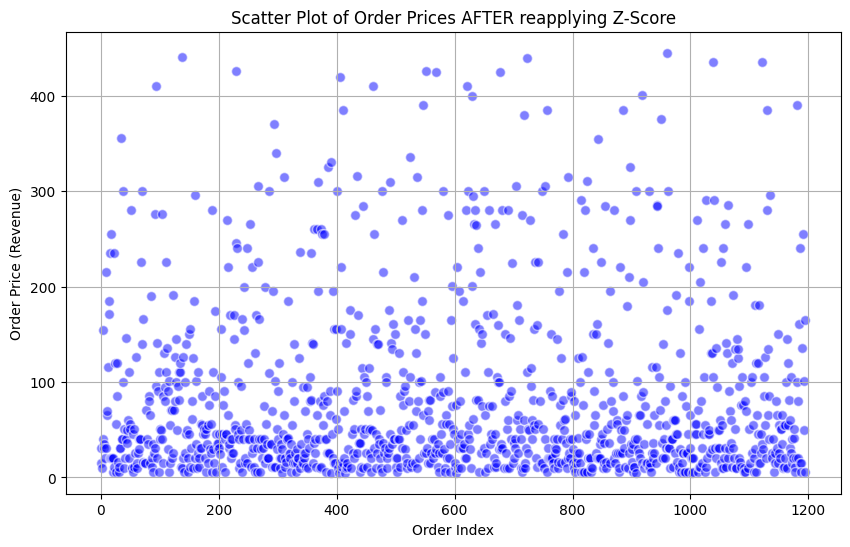

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(ordersdf.index, ordersdf['revenue'], alpha=0.5, c='blue', edgecolors='w', s=50)
plt.title('Scatter Plot of Order Prices AFTER reapplying Z-Score')
plt.xlabel('Order Index')
plt.ylabel('Order Price (Revenue)')
plt.grid(True)
plt.show()

Alright, we're ready to perform the same two fomer calculations, but now wtih <b>FILTERED DATA</b>

### 11. Statistical Significance of the Difference in Conversion Between Test Groups WITH FILTERED DATA

In [32]:
# Let's merge orders and visits data on date and group
conversion_data = pd.merge(
    ordersdf.groupby(['date', 'group']).agg(total_orders=('transaction_id', 'count')).reset_index(),
    visitsdf,
    on=['date', 'group']
)

# Let's calculate the conversion rate for each group and day
conversion_data['conversion_rate'] = conversion_data['total_orders'] / conversion_data['visits']

# Now, we aggregate the total number of orders and visits for each group
group_totals = conversion_data.groupby('group').agg(
    total_orders=('total_orders', 'sum'),
    total_visits=('visits', 'sum')
).reset_index()

# We're preparing the counts and totals for the z-test
counts = group_totals['total_orders'].values
totals = group_totals['total_visits'].values

# Perform the two-proportion z-test
z_stat, p_value = proportions_ztest(counts, totals)

print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")

# Let's print the results:
if p_value < 0.05:
    print("The difference in conversion rates between the groups AFTER STRIPPING OUTLUIER VALES is statistically significant.")
else:
    print("The difference in conversion rates between the groups AFTER STRIPPING OUTLUIER VALES is not statistically significant.")

Z-Statistic: -2.0907983415845237
P-Value: 0.03654614484581427
The difference in conversion rates between the groups AFTER STRIPPING OUTLUIER VALES is statistically significant.


Alright, there's no change with the former statistical test from the conversion rates between both groups.

### 12. Statistical Significance of the Difference in Average Order Size Between Test Groups WITH FILTERED DATA

This is our final statistical test between Group A and Group B:

In [33]:
# Separate the data for the two groups
group_A_orders = ordersdf[ordersdf['group'] == 'A']['revenue']
group_B_orders = ordersdf[ordersdf['group'] == 'B']['revenue']

# Perform an independent samples t-test
t_stat, p_value = ttest_ind(group_A_orders, group_B_orders, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Let's print results:
if p_value < 0.05:
    print("The difference in average order size between the groups AFTER STRIPPING OUTLUIER VALES is statistically significant.")
else:
    print("The difference in average order size between the groups AFTER STRIPPING OUTLUIER VALES is not statistically significant.")

T-Statistic: 0.27046663264417997
P-Value: 0.7868513520298712
The difference in average order size between the groups AFTER STRIPPING OUTLUIER VALES is not statistically significant.


Same as the former test with raw data; there's no change.

## FINAL CONCLUSIONS 

Based on the results of the tests, our possible recommendations are:

* a. For the test, consider one of the groups as the leader.
* b. For the test, conclude that there is no difference between the groups.
* c. Continue the test.

After thoroughly reviewing the project, including all analyses and visualizations, I conclude that there is a significant difference between the groups in terms of conversion rates, but not in terms of average order sizes. 

Therefore, <b>Group B can be considered as the leader</b>, based on its higher conversion rate.

<b>Final Conclusions and Inferences:</b>

* Cumulative Revenue by Group:
The cumulative revenue graph shows that Group B consistently outperforms Group A in terms of revenue generation. This suggests that the strategies or changes implemented for Group B are more effective in driving overall sales.

* Cumulative Average Order Size by Group:
The cumulative average order size reveals that Group A has a higher average order size compared to Group B. This means that while Group B generates more revenue overall, the average value of each order in Group A is higher.

* Relative Difference in Cumulative Average Order Size:
The relative difference graph indicates that Group B initially had a higher average order size, but Group A surpassed it mid-month. By the end of the period, Group A maintained a higher average order size, suggesting a shift in purchasing behavior.

* Conversion Rate:
Group B shows a higher conversion rate compared to Group A. This is significant because it demonstrates that the changes made in Group B were more effective in converting visits into purchases.

<b>Statistical Significance:</b>

* Conversion Rates: 
There is a statistically significant difference in conversion rates between Group A and Group B, with Group B showing a higher conversion rate. This confirms that the changes applied to Group B positively impacted conversion rates.

* Average Order Size: 
There is no statistically significant difference in the average order sizes between the groups, both with raw and filtered data. This suggests that the changes did not significantly affect the value of individual transactions.

<b>Final Recommendation:</b>

Based on the analysis, I recommend considering <b>Group B as the leader</b>. The higher conversion rate in Group B indicates that the changes made were effective in driving more purchases. However, future strategies should aim to balance both conversion rates and average order sizes to maximize overall revenue.

This balanced approach will help optimize the effectiveness of marketing strategies and ensure sustainable revenue growth for the store.

Thanks!

Ricardo Siller Cardenas